RODDA Ocean Application SANI
Imperial College London - CMCC
Authors: César Quilodrán-Casas and Marco Stefanelli


Loading the data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import glob
import pandas as pd
import netCDF4
import scipy
import numpy as np

In [2]:
directory_noDA = '../SHYFEM_NO_ASSIM/'
directory_DA = '../SHYFEM_ASSIM_BIVARIATE/'
list_of_paths_noDA = sorted(glob.glob(directory_noDA + '/*'))
list_of_paths_DA = sorted(glob.glob(directory_DA + '/*'))


In [3]:
sst_noDA = np.zeros((365*24, 90351))
count = 0
for file in list_of_paths_noDA:
    data_noDA = xr.open_dataset(file)
    sst_noDA[24*count:24*(count+1), :] = data_noDA.temperature
    count += 1
    

In [4]:
sst_DA = np.zeros((365*24, 90351))
count = 0
for file in list_of_paths_DA:
    data_DA = xr.open_dataset(file)
    sst_DA[24*count:24*(count+1), :] = data_DA.temperature
    count += 1

In [5]:
print(sst_noDA.shape)

(8760, 90351)


In [6]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

2022-10-08 09:09:42.348070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-08 09:09:44.078228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /zeus/opt/intel19.5/netcdf-threadsafe/C_4.7.2-F_4.5.2_CXX_4.3.1/lib:/zeus/opt/intel19.5/hdf5-threadsafe/1.10.5/lib:/zeus/opt/intel19.5/netcdf-threadsafe/C_4.7.2-F_4.5.2_CXX_4.3.1/lib:/zeus/opt/intel19.5/proj/6.2.1/lib:/zeus/opt/intel19.5/magics/3.3.1/lib:/zeus/opt/intel19.5/cdo/1.9.8/lib:/zeus/opt/intel19.5/eccodes/2.12.5//lib64:/zeus/opt/intel19.5/eccodes/2.12.5//lib:/zeus/opt/intel19.5/nco/4.8.1/l

In [7]:
nFeatures = sst_noDA.shape[1]
encoder_inputs = keras.Input(shape=nFeatures)
alpha = 0.3

enc = keras.layers.Dense(512)(encoder_inputs)
enc = keras.layers.LeakyReLU(alpha)(enc)
enc = keras.layers.Dropout(0.5)(enc)
enc = keras.layers.BatchNormalization()(enc)

enc = keras.layers.Dense(256)(enc)
enc = keras.layers.LeakyReLU(alpha)(enc)
enc = keras.layers.Dropout(0.5)(enc)
enc = keras.layers.BatchNormalization()(enc)

enc = keras.layers.Dense(128)(enc)
enc = keras.layers.LeakyReLU(alpha)(enc)
enc = keras.layers.Dropout(0.5)(enc)
enc = keras.layers.BatchNormalization()(enc)

enc = keras.layers.Dense(256)(enc)
enc = keras.layers.LeakyReLU(alpha)(enc)
enc = keras.layers.Dropout(0.5)(enc)
enc = keras.layers.BatchNormalization()(enc)

enc = keras.layers.Dense(512)(enc)
enc = keras.layers.LeakyReLU(alpha)(enc)
enc = keras.layers.Dropout(0.5)(enc)
enc = keras.layers.BatchNormalization()(enc)

output = keras.layers.Dense(nFeatures)(enc)
#enc = keras.layers.LeakyReLU(alpha)(enc)
#enc = keras.layers.Dropout(0.5)(enc)
#enc = keras.layers.BatchNormalization()(enc)

encoder = keras.Model(encoder_inputs, output, name="encoder")
encoder.summary()

2022-10-08 09:10:28.973928: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /zeus/opt/intel19.5/netcdf-threadsafe/C_4.7.2-F_4.5.2_CXX_4.3.1/lib:/zeus/opt/intel19.5/hdf5-threadsafe/1.10.5/lib:/zeus/opt/intel19.5/netcdf-threadsafe/C_4.7.2-F_4.5.2_CXX_4.3.1/lib:/zeus/opt/intel19.5/proj/6.2.1/lib:/zeus/opt/intel19.5/magics/3.3.1/lib:/zeus/opt/intel19.5/cdo/1.9.8/lib:/zeus/opt/intel19.5/eccodes/2.12.5//lib64:/zeus/opt/intel19.5/eccodes/2.12.5//lib:/zeus/opt/intel19.5/nco/4.8.1/lib:/zeus/opt/impi19.5/esmf/7.1.0/esmf-7.1.0-intelmpi-64-O/lib:/zeus/opt/intel19.5/udunits/2.2.26/lib:/zeus/opt/intel19.5/netcdf/C_4.7.2-F_4.5.2_CXX_4.3.1/lib:/zeus/opt/intel19.5/szip/2.1.1/lib:/zeus/opt/curl/7.66.0/lib:/zeus/opt/intel19.5/hdf5/1.10.5/lib:/zeus/opt/intel19.5/netcdf/C_4.7.2-F_4.5.2_CXX_4.3.1/lib:/zeus/opt/intel_2019/intel/compilers_and_librari

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90351)]           0         
                                                                 
 dense (Dense)               (None, 512)               46260224  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                           

In [8]:
n_samples = sst_noDA.shape[0]
indices = np.arange(n_samples)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(sst_noDA, sst_DA, indices, test_size = 0.2, random_state = 42, shuffle=True)
encoder.compile(loss='mse', optimizer=tf.optimizers.Adam())

In [124]:
encoder.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=10, batch_size=256)

Epoch 1/10
28/28 [==============================] - 13s 451ms/step - loss: 1.0384 - val_loss: 0.4780
Epoch 2/10
28/28 [==============================] - 10s 369ms/step - loss: 1.1393 - val_loss: 0.4264
Epoch 3/10
28/28 [==============================] - 10s 373ms/step - loss: 1.1402 - val_loss: 1.0948
Epoch 4/10
28/28 [==============================] - 10s 375ms/step - loss: 1.1975 - val_loss: 0.5755
Epoch 5/10
28/28 [==============================] - 10s 368ms/step - loss: 1.0718 - val_loss: 0.5176
Epoch 6/10
28/28 [==============================] - 10s 367ms/step - loss: 1.0323 - val_loss: 0.8754
Epoch 7/10
28/28 [==============================] - 10s 362ms/step - loss: 1.1146 - val_loss: 0.8163
Epoch 8/10
28/28 [==============================] - 10s 358ms/step - loss: 1.0320 - val_loss: 0.8967
Epoch 9/10
28/28 [==============================] - 11s 389ms/step - loss: 1.0589 - val_loss: 1.4261
Epoch 10/10
28/28 [==============================] - 12s 430ms/step - loss: 1.1202 - val_lo

In [125]:
# Read lon lat
lon_lat = xr.open_dataset('lon_lat_sani.nc')
lon = lon_lat.longitude.values
lat = lon_lat.latitude.values
index = indices_test[42]


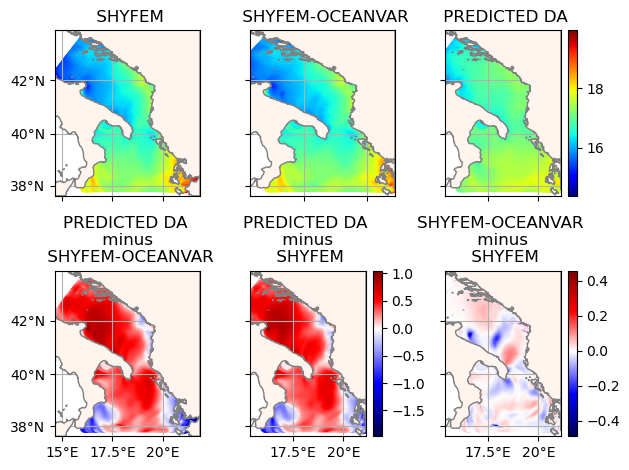

In [126]:
fig, axs = plt.subplots(nrows=2, ncols=3,sharex='col', sharey='row',subplot_kw={'projection': 'mercator'})
axs[0,0].set_title(" SHYFEM")
axs[0,0].coastline('medsea_h.shp', sea=None, zorder=2)
axs[0,0].scatter(lon,lat,c=sst_noDA[index, :], 
                 vmin=np.min(sst_DA[index, :]), 
                 vmax=np.max(sst_DA[index, :]), 
                 cmap='jet')

axs[0,1].set_title(" SHYFEM-OCEANVAR")
axs[0,1].coastline('medsea_h.shp', sea=None, zorder=2)
axs[0,1].scatter(lon,lat,c=sst_DA[index, :], 
                 vmin=np.min(sst_DA[index, :]), 
                 vmax=np.max(sst_DA[index, :]), 
                 cmap='jet')

axs[0,2].set_title(" PREDICTED DA")
axs[0,2].coastline('medsea_h.shp', sea=None, zorder=2)
cb1=axs[0,2].scatter(lon,lat,c=predDA[:], 
                     vmin=np.min(sst_DA[index, :]), 
                     vmax=np.max(sst_DA[index, :]), 
                     cmap='jet')

cbar1 = fig.colorbar(cb1, ax=axs[0][2])

###########################################################################################################################

axs[1,0].set_title("PREDICTED DA \n minus \n SHYFEM-OCEANVAR")
axs[1,0].coastline('medsea_h.shp', sea=None, zorder=2)
axs[1,0].scatter(lon,lat,c=predDA[:]-sst_DA[index, :],
                 cmap='seismic', norm=TwoSlopeNorm(vcenter=0.,
                                                   vmin=np.min(predDA[:]-sst_DA[index, :]), 
                                                   vmax=np.max(predDA[:]-sst_DA[index, :])))

axs[1,1].set_title("PREDICTED DA \n minus \n SHYFEM")
axs[1,1].coastline('medsea_h.shp', sea=None, zorder=2)
cb2=axs[1,1].scatter(lon,lat,c=predDA[:]-sst_noDA[index, :],
                 cmap='seismic', norm=TwoSlopeNorm(vcenter=0.,
                                                   vmin=np.min(predDA[:]-sst_DA[index, :]), 
                                                   vmax=np.max(predDA[:]-sst_DA[index, :])))

cbar2 = fig.colorbar(cb2, ax=axs[1][1])

axs[1,2].set_title("SHYFEM-OCEANVAR \n minus \n SHYFEM")
axs[1,2].coastline('medsea_h.shp', sea=None, zorder=2)
cb3=axs[1,2].scatter(lon,lat,c=sst_DA[index, :]-sst_noDA[index, :], 
                     cmap='seismic', norm=TwoSlopeNorm(vcenter=0.,
                                                       vmin=np.min(sst_DA[index, :]-sst_noDA[index, :]), 
                                                       vmax=np.max(sst_DA[index, :]-sst_noDA[index, :])))

cbar3 = fig.colorbar(cb3, ax=axs[1][2])



fig.tight_layout()
plt.savefig('10_epochs.png')